# Page rank

## Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

import networkx as nx
import graphviz as gv

## Network classes

In [2]:
class Page:
    """A class representing a webpage."""
    def __init__(self, name):
        """Constructor method, takes the name of the webpage as an argument."""
        self.name = name
        self.links = []
        
    def __repr__(self):
        """A page is represented by its name."""
        return self.name
    
    def addLinkTo(self, other):
        """Adds a link to another page"""
        self.links.append(other)
        
    def outDegree(self):
        """Returns the amount of links this page has i.e. its out-degree"""
        return len(self.links)
    
    def getName(self):
        return self.name

In [3]:
class Network:
    """A class representing a network of webpages"""
    def __init__(self):
        """A network starts without any pages."""
        self.pages = []
        self.counter = 0
        
        # Whether the dataframe is out of date
        self.old_df = True
    
    def __iter__(self):
        """Iterating over a network is the same as iterating over its pages."""
        return iter(self.pages)
        
    def addPage(self, page: Page):
        """Adds a page to the network"""
        # give the page an id (since the name of the webpage doesn't have to be unique)
        page.id = self.counter
        self.counter += 1
        self.pages.append(page)
        
        # Dataframe is out of date now
        self.old_df = True
        
    def addPages(self, *args):
        """Adds multiple pages to the network"""
        for page in args:
            self.addPage(page)
        
    def getPages(self):
        """Returns the pages in the network."""
        return self.pages
    
    def size(self):
        """Returns the size of the network."""
        return len(self.pages)
    
    def showRanking(self):
        """
        Prints the pages with their corresponding rank. 
        Not sorted on anything in particular, prints in increasing id.
        """
        for page in self:
            print(f'{page.name}: {page.rank}')
    
    # ----------------------------------------------------------
    # --------------------- VISUALIZATION ----------------------
    # ----------------------------------------------------------
    
    # ------------------- NODE-LINK DIAGRAMS ------------------- 
    def nxDiGraph(self):
        """Calculates networkx DiGraph"""
        # make a directed graph
        G = nx.DiGraph()
        
        # add all the edges and nodes to it
        for page in self:
            G.add_node(page)
            for other in page.links:
                G.add_edge(page, other)
        
        return G
    
    def plot1(self, names=False):
        """
        Plot using networkx.
        Node size based on *number of links*
        """
        G = self.nxDiGraph()
        
        # calculate a layout (force-directed)
        pos = nx.layout.spring_layout(G)

        # scale nodes by amount of links
        node_sizes = [1000 + 3000*len(page.links) for page in G.nodes()]
        
        if not names:
            # labels
            labels = {page:page.id for page in G.nodes()}
            
            nx.draw(G, pos, with_labels=True, labels=labels, node_size=node_sizes, arrowsize=40, font_color="white")
        else:
            nx.draw(G, pos, with_labels=True, node_size=node_sizes, arrowsize=40, font_color="white")
        plt.show()
    
    def plot2(self, names=False):
        """Plot using networkx. Node size based on *rank*"""
        G = self.nxDiGraph()
        
        # calculate a layout (force-directed)
        pos = nx.layout.spring_layout(G)

        # scale nodes by rank
        node_sizes = [1000 + 3000*page.rank for page in G.nodes()]
        
        if not names:
            # labels
            labels = {page:page.id for page in G.nodes()}
            
            nx.draw(G, pos, with_labels=True, labels=labels, node_size=node_sizes, arrowsize=40, font_color="white")
        else:
            nx.draw(G, pos, with_labels=True, node_size=node_sizes, arrowsize=40, font_color="white")
        plt.show()
        
    def plot0(self):
        """Plot using graphviz"""
        f = gv.Digraph()
        for page in self:
            f.node(str(page))
            for other in page.links:
                f.edge(str(page), str(other))

        return f
    
    # ----------------------- STATISTICS -----------------------
    def updateDf(self):
        """Update pandas DataFrame of this network."""
        
        # Prepare a dataframe
        df = pd.DataFrame(columns=['Name', 'Outdegree', 'Indegree'])
        
        df['Name'] = list(map(Page.getName, self.pages))
        df['Outdegree'] = list(map(Page.outDegree, self.pages))
        df.fillna(0, inplace=True)
        
        # Count indegree of every page
        for page in self:
            for link in page.links:
                df.at[link.id, 'Indegree'] += 1
        
        # Update dataframe
        self.df = df
        self.old_df = False
        
    def plot_outdegrees(self):
        """Plots a histogram of the outdegree of the pages in the network."""
        if self.old_df:
            self.updateDf()
        
        ax = sns.distplot(self.df['Outdegree'], kde=False, rug=True)
        ax.set_xlabel("Outdegree (number of links to other pages)")
        ax.set_ylabel("Frequency")
        
    def plot_indegrees(self):
        """Plots a histogram of the indegree of the pages in the network."""
        if self.old_df:
            self.updateDf()
        
        ax = sns.distplot(self.df['Indegree'], kde=False, rug=True)
        ax.set_xlabel("Indegree (number of links to this page from other pages)")
        ax.set_ylabel("Frequency")
        
    def describe(self):
        """Prints a table of summary statistics of this network."""
        if self.old_df:
            self.updateDf()
            
        return self.df.describe()
    
    def getDf(self):
        """Returns the dataframe of this network, updates it when needed."""
        if self.old_df:
            self.updateDf()
            
        return self.df
    
    def sinks(self):
        """Returns the sinks of the network."""
        if self.old_df:
            self.updateDf()
            
        return self.df[self.df['Outdegree'] == 0]
        
    def sources(self):
        """Returns the sources of the network."""
        if self.old_df:
            self.updateDf()
            
        return self.df[self.df['Indegree'] == 0]

### Example

In [4]:
wiki = Page("Wikipedia")
yt = Page("YouTube")
twitter = Page("Twitter")

wiki.addLinkTo(yt)
wiki.addLinkTo(twitter)
yt.addLinkTo(twitter)
twitter.addLinkTo(yt)

In [5]:
internet = Network()
internet.addPages(yt, wiki, twitter)

In [6]:
pages = internet.getPages()
pages

[YouTube, Wikipedia, Twitter]

In [7]:
pages[1].links

[YouTube, Twitter]

In [8]:
with open("california.txt") as f:
    content = f.read().splitlines()

In [9]:
california = Network()
for line in content:
    if line[0] == 'n':
        california.addPage(Page(line.split()[2]))
    elif line[0] == 'e':
        n1 = california.pages[int(line.split()[1])]
        n2 = california.pages[int(line.split()[2])]
        
        n1.addLinkTo(n2)

## Ranking the pages

In [10]:
class PageRanker:
    """A static class for ranking a network."""
    
    @staticmethod
    def rank(network: Network, steps: int, alpha: float):
        """
        Ranks a network via the PageRank algorithm.
        
        --- Parameters ---
        network: The Network to rank.
        steps: The number of iterations to do.
        alpha: The probability of going to another page via clicking a link.
        """
        PageRanker.calculateInitialRanking(network)
        PageRanker.calculateJumpingProbabilities(network)
        
        newRanks = {}
        for _ in range(0, steps):
            for page in network:
                newRanks[page] = 0
                for other in page.links:
                    newRanks[page] += other.rank / page.outDegree()
                newRanks[page] *= alpha
                newRanks[page] += (1-alpha) * page.q
                
        for page in network:
            page.rank = newRanks[page]
    
    @staticmethod
    def calculateInitialRanking(network: Network):
        """
        Calculates an initial ranking for the given network.
        Currently just gives each page a ranking of 1 / size of the network.
        """
        for page in network:
            page.rank = 1 / network.size()
            
    @staticmethod
    def calculateJumpingProbabilities(network: Network):
        """Calculates the probabilities of jumping to each page."""
        for page in network:
            page.q = 1 / network.size()

### Example

In [11]:
PageRanker.rank(internet, 1000, 0.5)

In [12]:
internet.showRanking()

YouTube: 0.3333333333333333
Wikipedia: 0.3333333333333333
Twitter: 0.3333333333333333


In [13]:
PageRanker.rank(california, 100, 0.5)

In [14]:
california.showRanking()

http://www.berkeley.edu/: 0.00010347682119205298
http://www.caltech.edu/: 0.00010347682119205298
http://www.realestatenet.com/: 0.00010347682119205298
http://www.ucsb.edu/: 0.00010347682119205297
http://www.washingtonpost.com/wp-srv/national/longterm/50states/ca.htm: 0.00010347682119205301
http://www-ucpress.berkeley.edu/: 0.00010347682119205298
http://www.ucr.edu/: 0.00010347682119205298
http://www.tegnetcorporation.com/: 0.00010347682119205298
http://www.research.digital.com/SRC/virtual-tourist/California.html: 0.00010347682119205298
http://www.leginfo.ca.gov/calaw.html: 5.173841059602649e-05
http://www.csun.edu/: 0.00010347682119205298
http://www.calpoly.edu/: 0.00010347682119205298
http://www.calbar.org/: 0.00010347682119205298
http://ideas.uqam.ca/ideas/data/fthcalaec.html: 5.173841059602649e-05
http://www.sen.ca.gov/: 0.00010347682119205298
http://www.csupomona.edu/: 5.173841059602649e-05
http://www.csuchico.edu/: 5.173841059602649e-05
http://www.calacademy.org/: 0.00010347682119

http://www.usda.gov/rus/electric/utilist1.htm: 5.173841059602649e-05
http://www.deregulation.com/links.html: 0.00010347682119205298
http://www.magicnet.net/~metzler/page2d.html: 0.00010347682119205298
http://www.ala.org/oitp/state.html: 5.173841059602649e-05
http://www.wideweb.com/baby/fav1.html: 5.173841059602649e-05
http://www.accesscom.com/~dave6592/govt.html: 0.000103476821192053
http://www.geocities.com/Eureka/1905/: 0.00010347682119205298
http://www.custom-env.com/favorite.htm: 0.00010347682119205298
http://www.dca.ca.gov/r_r/r_rtoc.htm: 0.00010347682119205298
http://www.hawaii.gov/lrb/ress.html: 0.000103476821192053
http://www.pirg.org/calpirg/links.htm: 0.00010347682119205302
http://www.energyonline.com/Restructuring/news_reports/cpuc/cpucfil1.html: 0.00010347682119205298
http://netfind.aol.com/aol/Reviews/Politics_and_Law/Governments/United_States/State/California/index.netfind.html: 0.00010347682119205298
http://www.gualcogroup.com/htd/link.html: 0.00010347682119205298
http:/

http://admissions.ucsd.edu/: 5.173841059602649e-05
http://www.worldartmag.com/links/index.html: 5.173841059602649e-05
http://www.cmp.ucr.edu/Bloomfield/Bloomfield/LisaBloomfield.html: 0.00010347682119205298
http://wwar.com/data/glass.html: 5.173841059602649e-05
http://www.wwar.com/data/glass.html: 5.173841059602649e-05
http://www.mediahistory.com//photo.html: 5.173841059602649e-05
http://www.mediahistory.com/photo.html: 5.173841059602649e-05
http://www.encyberpedia.com/museums.htm: 0.00010347682119205298
http://www.rbuhsd.k12.ca.us/subdirpgs/bookmark.html: 0.00010347682119205298
http://kerstein.com/museums.htm: 5.173841059602649e-05
http://www.netmation.com/www/phottd.htm: 5.173841059602649e-05
http://mediahistory.com/photo.html: 5.173841059602649e-05
http://www.cmp.ucr.edu/Bloomfield/aboutthepiece.html: 0.00010347682119205298
http://www.wwar.com/creator/stone.html: 5.173841059602649e-05
http://www.cs.toronto.edu/~mes/russia/sev-zap/museums.html: 5.173841059602649e-05
http://www-cse.uc

http://www.biabuild.com/baldy/index.htm: 5.173841059602649e-05
http://www.fredcowolf.com/links.htm: 0.00010347682119205298
http://www.snowcrest.net/bgorski/index3.htm: 0.00010347682119205298
http://gocalif.ca.gov/guidebook/SC/: 5.173841059602649e-05
http://www.gocalif.ca.gov/guidebook/SC/: 5.173841059602649e-05
http://www.primenet.com/~flyboy1/links.htm: 0.00010347682119205298
http://www.shastanet.org/edc/edc_tr.html: 5.173841059602649e-05
http://www.inet-marketing.com/shastasights/: 5.173841059602649e-05
http://www.sonic.net/layne/biolayne.html: 0.00010347682119205298
http://www.sonic.net/~layne/biolayne.html: 0.00010347682119205298
http://www.historyoftheworld.com/soquel/calhist2.htm: 0.000103476821192053
http://cavern.com/caves.htm: 5.173841059602649e-05
http://www.geocities.com/Yosemite/2542/norcal.htm: 5.173841059602649e-05
http://www.almanor.com/local.html: 5.173841059602649e-05
http://www.compuology.com/cagenweb/lassecty.htm: 0.00010347682119205298
http://plumas.com/plumas/pluma

http://www.bayinsider.com/getout/golf/: 0.00010347682119205298
http://www.bayinsider.com/getout/cycling/: 0.00010347682119205298
http://www.cimedia.com/: 5.173841059602649e-05
http://www.geophys.washington.edu/seismosurfing.html: 0.00010347682119205298
http://ceres.ca.gov/planning/state.html: 0.00010347682119205298
http://www.ceres.ca.gov/theme/geology.html: 0.00010347682119205298
http://www-socal.wr.usgs.gov/seismolinks.html: 5.173841059602649e-05
http://www.iga.ca.gov/env_law/state.html: 5.173841059602649e-05
http://www.info-mine.com/technomine/world/usa.html: 5.173841059602649e-05
http://www.alexandria.ucsb.edu/other-sites/title_page.html: 5.173841059602649e-05
http://farm.fic.niu.edu/fic/states/california.html: 0.00010347682119205298
http://scilib.ucsd.edu/sio/inst/: 5.173841059602649e-05
http://www.geo.berkeley.edu/seismo/resource/internet.html: 0.00010347682119205298
http://www.phoaks.com/phoaks2/newsgroups/sci/geo/earthquakes/index.html: 5.173841059602649e-05
http://www-cse.ucsd

http://web.inter.nl.net/users/H.Ranter/: 5.173841059602649e-05
http://www.airtanker.com/aap/memorial.htm: 5.173841059602649e-05
http://www.ihogman.com/ihfa/: 5.173841059602649e-05
http://www.gate.net/~avcrash/: 0.00010347682119205298
http://www.primenet.com/~kebab/: 5.173841059602649e-05
http://www.cap.af.mil/nhq/dp/dpm/Wing_Unit/wngwww.html: 5.173841059602649e-05
http://www.lostbirds.com/home.htm: 5.173841059602649e-05
http://airspacemag.earthlink.net/: 5.173841059602649e-05
http://www2.dk-online.dk/users/klaus_velschow/kola/index.htm: 5.173841059602649e-05
http://tristate.pgh.net/~bsilver/bomber.htm: 5.173841059602649e-05
http://www.spacecom.af.mil/21sw/a10/: 5.173841059602649e-05
http://life.csu.edu.au/~dspennem/MILARCH/Abstract_B.html: 5.173841059602649e-05
http://www2.interconnect.net/holan/airwar.htm: 5.173841059602649e-05
http://www.pbs.org/wgbh/nova/transcripts/2303b29.html: 5.173841059602649e-05
http://www3.sympatico.ca/scott.knox/: 5.173841059602649e-05
http://www.airspacemag

## Visualization of (small) networks

### With networkx

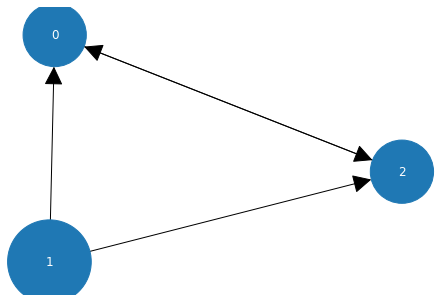

In [15]:
# size based on links
internet.plot1()

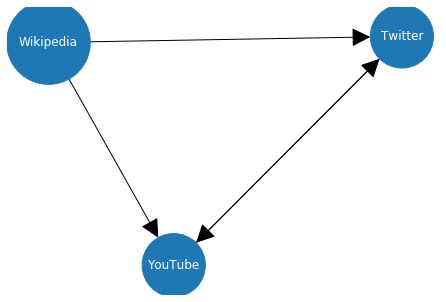

In [16]:
# plot with names (works in this case, but often labels are too large for the nodes)
internet.plot1(names=True)

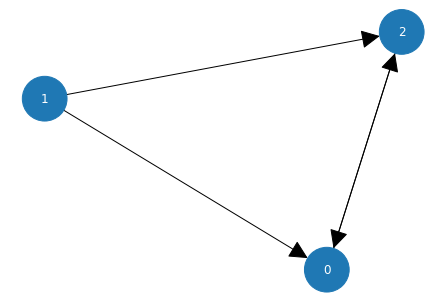

In [17]:
#size based on rank
internet.plot2()

### With graphviz

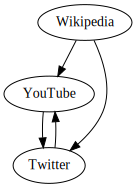

In [18]:
internet.plot0()

## Example with anomaly

In [19]:
internetV2= Network()
homepage = Page("Homepage")
for i in range(0,99):
    p = Page("test" + str(i))
    homepage.addLinkTo(p)
    internetV2.addPage(p)
internetV2.addPage(homepage)
PageRanker.rank(internetV2, 1000, 0.5)
internetV2.showRanking()

test0: 0.005
test1: 0.005
test2: 0.005
test3: 0.005
test4: 0.005
test5: 0.005
test6: 0.005
test7: 0.005
test8: 0.005
test9: 0.005
test10: 0.005
test11: 0.005
test12: 0.005
test13: 0.005
test14: 0.005
test15: 0.005
test16: 0.005
test17: 0.005
test18: 0.005
test19: 0.005
test20: 0.005
test21: 0.005
test22: 0.005
test23: 0.005
test24: 0.005
test25: 0.005
test26: 0.005
test27: 0.005
test28: 0.005
test29: 0.005
test30: 0.005
test31: 0.005
test32: 0.005
test33: 0.005
test34: 0.005
test35: 0.005
test36: 0.005
test37: 0.005
test38: 0.005
test39: 0.005
test40: 0.005
test41: 0.005
test42: 0.005
test43: 0.005
test44: 0.005
test45: 0.005
test46: 0.005
test47: 0.005
test48: 0.005
test49: 0.005
test50: 0.005
test51: 0.005
test52: 0.005
test53: 0.005
test54: 0.005
test55: 0.005
test56: 0.005
test57: 0.005
test58: 0.005
test59: 0.005
test60: 0.005
test61: 0.005
test62: 0.005
test63: 0.005
test64: 0.005
test65: 0.005
test66: 0.005
test67: 0.005
test68: 0.005
test69: 0.005
test70: 0.005
test71: 0.005
te

In [20]:
PageRanker.rank(internetV2, 1000, 0.1)
internetV2.showRanking()

test0: 0.009000000000000001
test1: 0.009000000000000001
test2: 0.009000000000000001
test3: 0.009000000000000001
test4: 0.009000000000000001
test5: 0.009000000000000001
test6: 0.009000000000000001
test7: 0.009000000000000001
test8: 0.009000000000000001
test9: 0.009000000000000001
test10: 0.009000000000000001
test11: 0.009000000000000001
test12: 0.009000000000000001
test13: 0.009000000000000001
test14: 0.009000000000000001
test15: 0.009000000000000001
test16: 0.009000000000000001
test17: 0.009000000000000001
test18: 0.009000000000000001
test19: 0.009000000000000001
test20: 0.009000000000000001
test21: 0.009000000000000001
test22: 0.009000000000000001
test23: 0.009000000000000001
test24: 0.009000000000000001
test25: 0.009000000000000001
test26: 0.009000000000000001
test27: 0.009000000000000001
test28: 0.009000000000000001
test29: 0.009000000000000001
test30: 0.009000000000000001
test31: 0.009000000000000001
test32: 0.009000000000000001
test33: 0.009000000000000001
test34: 0.00900000000000

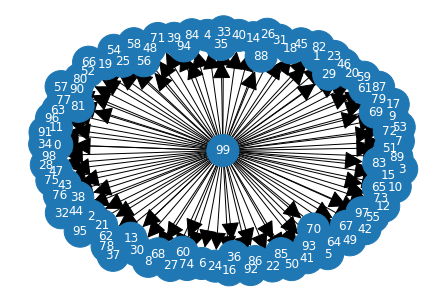

In [21]:
internetV2.plot2()

### Reverse

In [22]:
internetV3= Network()
endpage = Page("Endpage")
for i in range(0,99):
    p = Page("test" + str(i))
    p.addLinkTo(endpage)
    internetV3.addPage(p)
internetV3.addPage(endpage)
PageRanker.rank(internetV3, 1000, 0.5)
internetV3.showRanking()

test0: 0.01
test1: 0.01
test2: 0.01
test3: 0.01
test4: 0.01
test5: 0.01
test6: 0.01
test7: 0.01
test8: 0.01
test9: 0.01
test10: 0.01
test11: 0.01
test12: 0.01
test13: 0.01
test14: 0.01
test15: 0.01
test16: 0.01
test17: 0.01
test18: 0.01
test19: 0.01
test20: 0.01
test21: 0.01
test22: 0.01
test23: 0.01
test24: 0.01
test25: 0.01
test26: 0.01
test27: 0.01
test28: 0.01
test29: 0.01
test30: 0.01
test31: 0.01
test32: 0.01
test33: 0.01
test34: 0.01
test35: 0.01
test36: 0.01
test37: 0.01
test38: 0.01
test39: 0.01
test40: 0.01
test41: 0.01
test42: 0.01
test43: 0.01
test44: 0.01
test45: 0.01
test46: 0.01
test47: 0.01
test48: 0.01
test49: 0.01
test50: 0.01
test51: 0.01
test52: 0.01
test53: 0.01
test54: 0.01
test55: 0.01
test56: 0.01
test57: 0.01
test58: 0.01
test59: 0.01
test60: 0.01
test61: 0.01
test62: 0.01
test63: 0.01
test64: 0.01
test65: 0.01
test66: 0.01
test67: 0.01
test68: 0.01
test69: 0.01
test70: 0.01
test71: 0.01
test72: 0.01
test73: 0.01
test74: 0.01
test75: 0.01
test76: 0.01
test77: 0

## Statistics

In [23]:
internet.sources()

,Name,Outdegree,Indegree
1,Wikipedia,2,0


In [24]:
internet.sinks()

,Name,Outdegree,Indegree


In [25]:
california.sinks()

,Name,Outdegree,Indegree
9,http://www.leginfo.ca.gov/calaw.html,0,155
13,http://ideas.uqam.ca/ideas/data/fthcalaec.html,0,0
15,http://www.csupomona.edu/,0,36
16,http://www.csuchico.edu/,0,32
33,http://www.ftb.ca.gov/,0,46
...,...,...,...
9655,http://www.fleamarket.net/,0,0
9658,http://remco.com/fun.html,0,0
9660,http://www.maxwellstreet.org/,0,0
9661,http://village.ios.com/~internet/,0,0


In [26]:
california.sources()

,Name,Outdegree,Indegree
7,http://www.tegnetcorporation.com/,11,0
13,http://ideas.uqam.ca/ideas/data/fthcalaec.html,0,0
79,http://www.mapquest.com/wine/mqinterconnect,1,0
95,http://www.angelfire.com/ca/srcom/index.html,4,0
120,http://www.psn.net/support/access_num.phtml,2,0
...,...,...,...
9659,http://www.spd.louisville.edu/~mejenn01/handy....,1,0
9660,http://www.maxwellstreet.org/,0,0
9661,http://village.ios.com/~internet/,0,0
9662,http://www.meats.net/,0,0


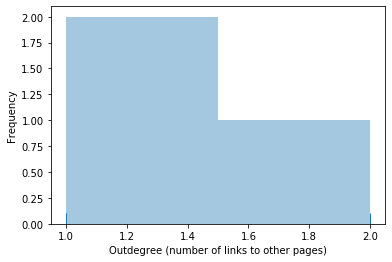

In [27]:
internet.plot_outdegrees()

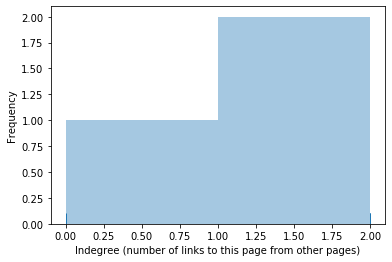

In [28]:
internet.plot_indegrees()

In [29]:
internet.describe()

,Outdegree,Indegree
count,3.000000,3.000000
mean,1.333333,1.333333
std,0.577350,1.154701
min,1.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,2.000000
75%,1.500000,2.000000
max,2.000000,2.000000


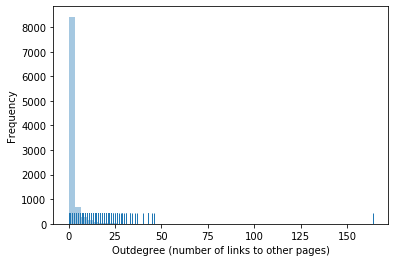

In [30]:
california.plot_outdegrees()

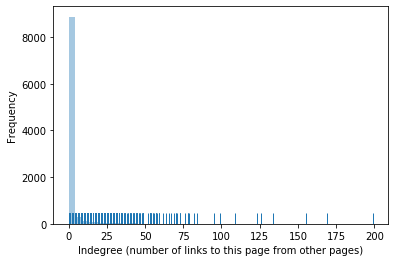

In [31]:
california.plot_indegrees()

In [32]:
california.describe()

,Outdegree,Indegree
count,9664.000000,9664.000000
mean,1.671151,1.671151
std,3.695696,7.457138
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.000000
max,164.000000,199.000000
